### Load Libraries and notebook config

In [60]:
# Load librairies and notebook config

import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np

from utils_data_cleansing import load_rules, apply_rule
from utils_geoloc import load_data, get_geoloc

pd.set_option('display.max_columns', 100)

### Loading Raw data

In [61]:
df = pd.read_csv('raw_data.csv', sep=";")

C:\Users\522381\AppData\Local\Temp\ipykernel_33864\2924384613.py:1: DtypeWarning:

Columns (33,34,38,39,43,49) have mixed types. Specify dtype option on import or set low_memory=False.



#### Data parsing & formating

In [62]:
df['Planned pickup date'] = pd.to_datetime(df['Planned pickup date'])
df['Planned delivery date'] = pd.to_datetime(df['Planned delivery date'])
df['Volume'] = pd.to_numeric(df['Volume'].str.replace(',', '.'))
df['Gross weight'] = pd.to_numeric(df['Gross weight'].str.replace(',', '.'))
df['Costs in EUR'] = pd.to_numeric(df['Costs in EUR'].str.replace(',', '.'))

C:\Users\522381\AppData\Local\Temp\ipykernel_33864\4088349006.py:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\522381\AppData\Local\Temp\ipykernel_33864\4088349006.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [63]:
# ======== Data Cleansing ========

def f_memoize_places(s):
    places = {place:apply_rule(place, rules_city) for place in s.unique()}
    return s.map(places)

rules = load_rules("rules.yml")
df['consignee_name_c'] = df['Consignee name'].apply(lambda x : apply_rule(x, rules))
df['loading_name_c'] = df['Loading location name'].apply(lambda x : apply_rule(x, rules))

rules_city = load_rules("rules_city.yml")
#df['consignee_city_c'] = df['Consignee city'].apply(lambda x : apply_rule(x, rules_city))
#df['loading_city_c'] = df['Loading location city'].apply(lambda x : apply_rule(x, rules_city))
df['consignee_city_c'] = f_memoize_places(df['Consignee city'])
df['loading_city_c'] = f_memoize_places(df['Loading location city'])

print("======== Consignee Name ========")
print(f"==> {len(df['Consignee name'].unique())}")
print(f"==> {len(df['consignee_name_c'].unique())}")

print("======== Consignee City ========")
print(f"==> {len(df['Consignee city'].unique())}")
print(f"==> {len(df['consignee_city_c'].unique())}")
df['consignee_U'] = df['consignee_name_c'].astype(str) + " - " + df['consignee_city_c']
df['loading_U'] = df['loading_name_c'].astype(str) + " - " + df['loading_city_c']

pd.Series(df['consignee_city_c'].value_counts()).to_csv('Location.csv', sep=";", encoding="utf8") #[df['consignee_loc_lat_U'] == 0.]
main_names = pd.concat([df['consignee_name_c'], df['loading_name_c']], axis=0)
pd.Series(main_names.sort_values().value_counts()).to_csv('CONSIGNEE_NAME.csv', sep=';')


======== Consignee Name ========
==> 4618
==> 2560
======== Consignee City ========
==> 2216
==> 1646


In [64]:
# Apply Geolocation

data = load_data("geoloc.yml")

df['consignee_loc_U'] = df['consignee_city_c'].apply(lambda x : get_geoloc(x, data))
df[['consignee_loc_lat_U', 'consignee_loc_lon_U']] = pd.DataFrame(df['consignee_loc_U'].to_list(), index=df.index)

df['loading_loc_U'] = df['loading_city_c'].apply(lambda x : get_geoloc(x, data))
df[['loading_loc_lat_U', 'loading_loc_lon_U']] = pd.DataFrame(df['loading_loc_U'].to_list(), index=df.index)

In [65]:
df[df['consignee_city_c'].str.startswith('Hi') == True]['consignee_city_c'].unique()

array(['Hildesheim', 'Hilpoltstein', 'Hilden', 'Hirschau',
       'Hisings Backa', 'Hilchenbach Müsen', 'Hilton', 'Hidalgo Sahagun'],
      dtype=object)

In [66]:
pd.Series(df[(df['consignee_loc_lat_U'] == 0.) & (df['consignee_loc_lon_U'] == 0.)]['consignee_city_c'].value_counts()).to_csv('Location.csv', sep=";", encoding="utf8")

### Display map of transport points in Europe

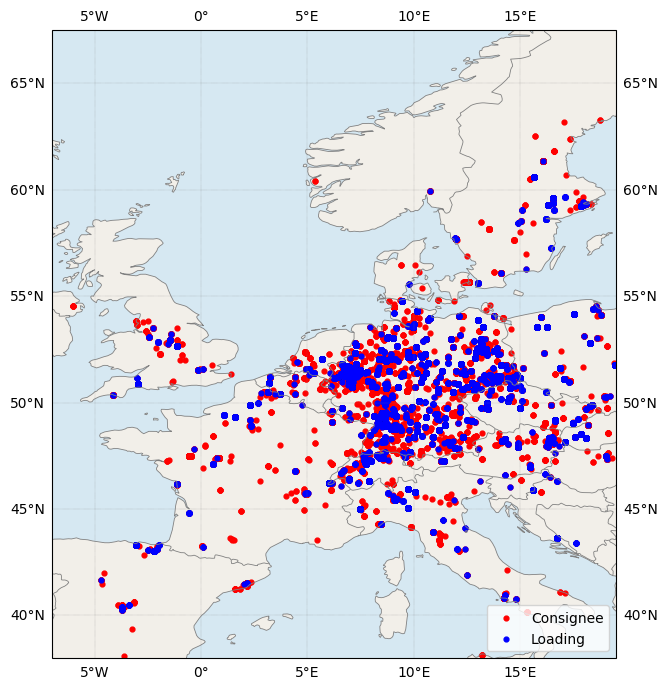

In [67]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection=ccrs.PlateCarree())  # your lon/lat are in PlateCarree

# --- background layers ---
ax.add_feature(cfeature.LAND, facecolor="#f2efe9")
ax.add_feature(cfeature.OCEAN, facecolor="#d6e8f2")
ax.add_feature(cfeature.BORDERS, linewidth=0.6, edgecolor="gray")
ax.add_feature(cfeature.COASTLINE, linewidth=0.6, edgecolor="gray")
ax.gridlines(draw_labels=True, linestyle=":", linewidth=0.3, color="gray")

# --- your data (lon, lat) ---
ax.scatter(df['consignee_loc_lon_U'], df['consignee_loc_lat_U'], c='r', s=12, transform=ccrs.PlateCarree(), label="Consignee")
ax.scatter(df['loading_loc_lon_U'], df['loading_loc_lat_U'], c='b', s=12, transform=ccrs.PlateCarree(), label="Loading")

# --- extent to Europe (xlim, ylim) ---
# Matplotlib: xlim(-7, 19.5), ylim(38, 67.5)
ax.set_extent([-7, 19.5, 38, 67.5], crs=ccrs.PlateCarree())

ax.legend(loc="lower right")
plt.tight_layout()
plt.show()


### Creation of Routes dataset

In [68]:
routes = pd.DataFrame(df.groupby(by=['consignee_U', "loading_U"])['TMS ID'].count().reset_index(drop=False))
routes['total_volume'] = df.groupby(by=['consignee_U', "loading_U"])['Volume'].sum().reset_index(drop=False)['Volume']
routes['avg_volume'] = df.groupby(by=['consignee_U', "loading_U"])['Volume'].mean().reset_index(drop=False)['Volume']
routes['total_gross_weight'] = df.groupby(by=['consignee_U', "loading_U"])['Gross weight'].sum().reset_index(drop=False)['Gross weight']
routes['total_costs'] = df.groupby(by=['consignee_U', "loading_U"])['Costs in EUR'].sum().reset_index(drop=False)['Costs in EUR']
routes['volume_variability'] = df.groupby(by=['consignee_U', "loading_U"])['Volume'].agg(vol_mean='mean', vol_sd=lambda s : s.std(ddof=1), vol_cv=lambda s : (s.std(ddof=1)/s.mean()) if s.mean() != 0 else None).reset_index(drop=False)['vol_cv']
weekly = (df.groupby(['consignee_U', 'loading_U']).resample('W-MON', on='Planned pickup date').size().rename('pickups').reset_index())
pickups_per_week = (weekly.groupby(['consignee_U', 'loading_U']).agg(pickups_per_week=('pickups', 'mean'),weeks=('pickups', 'size'),total_pickups=('pickups', 'sum')).reset_index())
routes = pd.merge(routes, pickups_per_week, left_on=['consignee_U', 'loading_U'], right_on=['consignee_U', 'loading_U']).sort_values(by="TMS ID", ascending=False)
routes['cost_per_unit'] = routes['total_costs'] / routes['total_volume']
routes

,consignee_U,loading_U,TMS ID,total_volume,avg_volume,total_gross_weight,total_costs,volume_variability,pickups_per_week,weeks,total_pickups,cost_per_unit
2120,Alstom - Netphen,Alstom - Hennigsdorf,1301,8657.4995,6.654496,6.783371e+06,647294.23,1.261095,5.062257,257,1301,74.766880
4328,Deutsche Bahn - München,Alstom - Hennigsdorf,1060,324.4024,0.306040,9.985900e+04,40099.93,1.357832,4.124514,257,1060,123.611693
7749,Stadtwerke Verkehrsgesellschaft - Frankfurt am...,Alstom - Bautzen,1039,340.1749,0.328038,5.953353e+04,53140.04,2.523866,4.106719,253,1039,156.213877
5072,Gruber - Kreuztal,Bochumer Verein Verkehrstechnik - Bochum,790,2199.9928,2.788331,1.392067e+06,118573.38,1.167908,3.073930,257,790,53.897167
1062,Alstom - Hennigsdorf,Alstom - Netphen,755,15832.4277,20.970103,5.821346e+06,583060.55,2.180875,2.937743,257,755,36.826983
...,...,...,...,...,...,...,...,...,...,...,...,...
5234,Hasler Rail - Berne,Alstom - Kassel,1,0.0569,0.056900,1.170000e+01,38.40,NaN,1.000000,1,1,674.868190
1543,Alstom - Kassel,Critical Software - Taveiro,1,0.1073,0.107300,7.000000e+00,138.23,NaN,1.000000,1,1,1288.257223
5237,Haupt Hydraulik & Pneumatik - Riesa,Alstom - Dusseldorf,1,0.0487,0.048700,1.730000e+01,46.46,NaN,1.000000,1,1,954.004107
5238,Hauptzollamt Berlin - Berlin,Alstom - Hennigsdorf,1,0.0037,0.003700,7.500000e-01,4.30,NaN,1.000000,1,1,1162.162162


### Reduction of scope

Only route with volume variability less than 0.6 are kept, routes with more 1 pickup or more per week are also kept

In [84]:
scope = routes[(routes['volume_variability'] < 0.6) & (routes['pickups_per_week'] >= 1)].reset_index(drop=True)
#scope = routes
scope.head()

,consignee_U,loading_U,TMS ID,total_volume,avg_volume,total_gross_weight,total_costs,volume_variability,pickups_per_week,weeks,total_pickups,cost_per_unit,consignee_loc_U,consignee_loc_lat_U,consignee_loc_lon_U,loading_loc_U,loading_loc_lat_U,loading_loc_lon_U
0,Gruber - Kreuztal,Alstom - Hennigsdorf,572,3564.0538,6.230863,1955190.0,170393.29,0.483439,3.058824,187,572,47.808843,"[50.96585943741652, 7.9917493119684595]",50.965859,7.991749,"[52.627679834305106, 13.210479376653874]",52.627680,13.210479
1,Alstom - Derby,Gruber - Kreuztal,466,14056.5623,30.164297,7839265.0,1429157.04,0.303046,2.427083,192,466,101.671875,"[52.9225, -1.4746]",52.922500,-1.474600,"[50.96585943741652, 7.9917493119684595]",50.965859,7.991749
2,Kuhne & Nagel - Chemnitz,Alstom - Hennigsdorf,291,253.3395,0.870582,229020.6,48741.22,0.417258,1.901961,153,291,192.394869,"[50.82553543993765, 12.929415057997684]",50.825535,12.929415,"[52.627679834305106, 13.210479376653874]",52.627680,13.210479
3,Hitachi - Pistoia,Alstom - Netphen,237,5989.2223,25.270980,3352027.5,480731.78,0.540474,1.030435,230,237,80.266144,"[43.9336, 10.9167]",43.933600,10.916700,"[50.9135798273003, 8.04645545489178]",50.913580,8.046455
4,Alstom - Netphen,Id Logistics France - Amiens,166,705.8144,4.251894,218992.0,53167.32,0.583813,1.129252,147,166,75.327622,"[50.9135798273003, 8.04645545489178]",50.913580,8.046455,"[49.89337335743366, 2.2994416353077534]",49.893373,2.299442


Geocoding of routes with departure & destination point

In [85]:
data = load_data("geoloc.yml")

scope['consignee_loc_U'] = scope['consignee_U'].apply(lambda x : get_geoloc(str(x).split(' - ')[-1], data))
scope[['consignee_loc_lat_U', 'consignee_loc_lon_U']] = pd.DataFrame(scope['consignee_loc_U'].to_list(), index=scope.index)

scope['loading_loc_U'] = scope['loading_U'].apply(lambda x : get_geoloc(str(x).split(' - ')[-1], data))
scope[['loading_loc_lat_U', 'loading_loc_lon_U']] = pd.DataFrame(scope['loading_loc_U'].to_list(), index=scope.index)

scope = scope.drop(columns = ['consignee_loc_U', "loading_loc_U"])

In [86]:
scope.head()

,consignee_U,loading_U,TMS ID,total_volume,avg_volume,total_gross_weight,total_costs,volume_variability,pickups_per_week,weeks,total_pickups,cost_per_unit,consignee_loc_lat_U,consignee_loc_lon_U,loading_loc_lat_U,loading_loc_lon_U
0,Gruber - Kreuztal,Alstom - Hennigsdorf,572,3564.0538,6.230863,1955190.0,170393.29,0.483439,3.058824,187,572,47.808843,50.965859,7.991749,52.627680,13.210479
1,Alstom - Derby,Gruber - Kreuztal,466,14056.5623,30.164297,7839265.0,1429157.04,0.303046,2.427083,192,466,101.671875,52.922500,-1.474600,50.965859,7.991749
2,Kuhne & Nagel - Chemnitz,Alstom - Hennigsdorf,291,253.3395,0.870582,229020.6,48741.22,0.417258,1.901961,153,291,192.394869,50.825535,12.929415,52.627680,13.210479
3,Hitachi - Pistoia,Alstom - Netphen,237,5989.2223,25.270980,3352027.5,480731.78,0.540474,1.030435,230,237,80.266144,43.933600,10.916700,50.913580,8.046455
4,Alstom - Netphen,Id Logistics France - Amiens,166,705.8144,4.251894,218992.0,53167.32,0.583813,1.129252,147,166,75.327622,50.913580,8.046455,49.893373,2.299442


Calculation of routes distances in kilometers

In [87]:
from geopy.distance import geodesic

# Compute distance in kilometers
scope['distance_km'] = df.apply(
    lambda row: geodesic((row['consignee_loc_lat_U'], row['consignee_loc_lon_U']), (row['loading_loc_lat_U'], row['loading_loc_lon_U'])).kilometers,
    axis=1)
scope['cost_per_unit'] = scope['total_costs'] / scope['distance_km']
scope['stability'] = 1 / (1+scope['volume_variability'])

In [88]:
def minmax(s):
    s = s.astype(float)
    return (s - s.min()) / (s.max()-s.min() + 1e-9)

scope["n_cost_per_unit"] = minmax(scope["cost_per_unit"])
scope["n_stability"]     = minmax(scope["stability"])


# "sweet spot" on avg volume: penalize too tiny and too big
# You need a capacity assumption (example: 33 pallets or 24t etc.)
CAP = 33
util = (scope['avg_volume'] / CAP).clip(0, 2)

# peaked preference near ~0.4–0.8 utilization for milk-run candidates
scope["util_pref"] = np.exp(-((util - 0.6) ** 2) / (2 * 0.25 ** 2))

scope["lane_milk_score"] = (
    0.45 * scope["n_cost_per_unit"] +
    0.35 * scope["n_stability"] +
    0.20 * scope["util_pref"]
)

Reduction of scope to keep only routes less than 1000 km

In [89]:
print("====== Distance split ======")
print(f"==> {len(scope)}")
scope = scope[scope['distance_km'] <= 1000]
print(f"==> {len(scope)}")

====== Distance split ======
==> 143
==> 135


In [91]:
scope.sort_values(by="lane_milk_score", ascending=False).head()

,consignee_U,loading_U,TMS ID,total_volume,avg_volume,total_gross_weight,total_costs,volume_variability,pickups_per_week,weeks,total_pickups,cost_per_unit,consignee_loc_lat_U,consignee_loc_lon_U,loading_loc_lat_U,loading_loc_lon_U,distance_km,stability,n_cost_per_unit,n_stability,util_pref,lane_milk_score
1,Alstom - Derby,Gruber - Kreuztal,466,14056.5623,30.164297,7839265.0,1429157.04,0.303046,2.427083,192,466,80206.728238,52.92250,-1.474600,50.965859,7.991749,17.818418,0.767433,1.000000,0.369073,0.454245,0.670025
125,CD Cargo - Ústí Nad Labem,Alstom - Netphen,2,34.2720,17.136000,28000.0,3600.00,0.000000,2.000000,1,2,9.873297,50.66670,14.033300,50.913580,8.046455,364.619833,1.000000,0.000123,1.000000,0.949201,0.539895
101,Ricolfi Spa - Marcianise Localita Ceraso,Alstom - Netphen,2,34.0000,17.000000,14280.0,10200.00,0.000000,1.000000,2,2,18.215963,41.01670,14.300000,50.913580,8.046455,559.948422,1.000000,0.000227,1.000000,0.944033,0.538909
67,Duisburger - duisburg,Pws - Netphen,2,47.9424,23.971200,32160.0,2875.00,0.000000,2.000000,1,2,4.942493,51.43440,6.762300,50.913580,8.046455,581.690248,1.000000,0.000061,1.000000,0.880016,0.526031
130,Alstom - Netphen,Dortmunder Eisenbahn - Dortmund,2,30.0000,15.000000,64000.0,1700.00,0.000000,2.000000,1,2,5.310053,50.91358,8.046455,51.514266,7.462707,320.147477,1.000000,0.000066,1.000000,0.844293,0.518888


In [92]:
outbound = scope.groupby("loading_U").agg(
    out_total_vol=("total_volume", "sum"),
    out_avg_vol=("avg_volume", "sum"),
    out_cost=("total_costs", "sum"),
    out_mean_stability=("stability", "mean"),
    out_lanes=("consignee_U", "nunique"),
)

inbound = scope.groupby("consignee_U").agg(
    in_total_vol=("total_volume", "sum"),
    in_avg_vol=("avg_volume", "sum"),
    in_cost=("total_costs", "sum"),
    in_mean_stability=("stability", "mean"),
    in_lanes=("loading_U", "nunique"),
)

nodes = outbound.join(inbound, how="outer").fillna(0)
nodes['two_way_intensity'] = nodes['out_total_vol'] + nodes['in_total_vol']
nodes.sort_values("two_way_intensity", ascending=False).head(10)


,out_total_vol,out_avg_vol,out_cost,out_mean_stability,out_lanes,in_total_vol,in_avg_vol,in_cost,in_mean_stability,in_lanes,two_way_intensity
Gruber - Kreuztal,14318.7463,112.785897,1453920.14,0.887109,4.0,3564.0538,6.230863,170393.29,0.674109,1.0,17882.8001
Alstom - Derby,0.0000,0.000000,0.00,0.000000,0.0,14056.5623,30.164297,1429157.04,0.767433,1.0,14056.5623
Alstom - Netphen,6226.2863,143.802980,511405.59,0.944112,12.0,1577.5381,134.271939,256051.27,0.865467,12.0,7803.8244
Hitachi - Pistoia,0.0000,0.000000,0.00,0.000000,0.0,6054.1823,57.750980,485906.78,0.824575,2.0,6054.1823
Alstom - Hennigsdorf,3818.6167,7.713146,219777.12,0.853507,10.0,1785.3276,85.872990,49471.51,0.859594,11.0,5603.9443
Alstom - Görlitz,0.9790,0.489500,418.95,0.899903,1.0,1662.2540,13.858935,83054.63,0.725109,3.0,1663.2330
Flachglas Wernberg - Wernberg Köblitz,1550.0000,10.064935,63519.52,0.762762,1.0,0.0000,0.000000,0.00,0.000000,0.0,1550.0000
Dillinger France ( Gts ) Gp3 Na Arcelor Dunkerque Site - Dunkerk,1465.7582,12.971312,155627.43,0.867761,1.0,0.0000,0.000000,0.00,0.000000,0.0,1465.7582
Lgi Czechia Sro - Zákupy,0.0000,0.000000,0.00,0.000000,0.0,1465.7582,12.971312,155627.43,0.867761,1.0,1465.7582
Transtec F&E Vetschau - Vetschau/Spreewald,1174.0800,65.226667,9450.00,0.996543,1.0,0.0000,0.000000,0.00,0.000000,0.0,1174.0800


In [93]:
alstom_sites = scope[['loading_U', 'loading_loc_lat_U', "loading_loc_lon_U"]].drop_duplicates().reset_index(drop=True) #[scope["loading_U"].str.contains('Alstom') == True]
alstom_sites.columns = ['site', "lat", 'lon']
alstom_sites

,site,lat,lon
0,Alstom - Hennigsdorf,52.627680,13.210479
1,Gruber - Kreuztal,50.965859,7.991749
2,Alstom - Netphen,50.913580,8.046455
3,Id Logistics France - Amiens,49.893373,2.299442
4,Flachglas Wernberg - Wernberg Köblitz,0.000000,0.000000
...,...,...,...
89,Alstom - Česká Lípa,50.684011,14.536608
90,Akiem - Krefeld,51.334239,6.569763
91,Annax - Brunnthal,48.006443,11.683673
92,Westermo Network Technologies - Eskilstuna,59.366700,16.516700


In [94]:
from sklearn.cluster import DBSCAN

sites = alstom_sites.dropna().copy()
coords = np.radians(sites[['lat', 'lon']].values)
eps = 200 / 6371

clust = DBSCAN(eps = eps, min_samples=3, metric="haversine")
sites['cluster'] = clust.fit_predict(coords)
sites['cluster'].value_counts()

cluster
 0    54
 1    13
 3    10
-1     9
 2     8
Name: count, dtype: int64

In [95]:
scope = scope.merge(sites[['site', 'cluster']], left_on="loading_U", right_on="site").rename(columns={"cluster" : "c_origin"})
scope = scope.merge(sites[['site', 'cluster']], left_on="consignee_U", right_on="site").rename(columns={"cluster" : "c_destination"})
scope

,consignee_U,loading_U,TMS ID,total_volume,avg_volume,total_gross_weight,total_costs,volume_variability,pickups_per_week,weeks,total_pickups,cost_per_unit,consignee_loc_lat_U,consignee_loc_lon_U,loading_loc_lat_U,loading_loc_lon_U,distance_km,stability,n_cost_per_unit,n_stability,util_pref,lane_milk_score,site_x,c_origin,site_y,c_destination
0,Gruber - Kreuztal,Alstom - Hennigsdorf,572,3564.0538,6.230863,1955190.000,170393.29,0.483439,3.058824,187,572,909.912720,50.965859,7.991749,52.627680,13.210479,187.263334,0.674109,1.134442e-02,0.115899,2.585694e-01,0.097383,Alstom - Hennigsdorf,0,Gruber - Kreuztal,0
1,Alstom - Netphen,Id Logistics France - Amiens,166,705.8144,4.251894,218992.000,53167.32,0.583813,1.129252,147,166,248.688268,50.913580,8.046455,49.893373,2.299442,213.791026,0.631388,3.100413e-03,0.000000,1.693320e-01,0.035262,Id Logistics France - Amiens,0,Alstom - Netphen,0
2,Alstom - Görlitz,Flachglas Wernberg - Wernberg Köblitz,154,1550.0000,10.064935,167648.680,63519.52,0.311025,1.013158,152,154,198.407061,51.150000,14.983300,0.000000,0.000000,320.147477,0.762762,2.473518e-03,0.356403,4.984713e-01,0.225548,Flachglas Wernberg - Wernberg Köblitz,1,Alstom - Görlitz,0
3,Alstom - Hennigsdorf,Gve Viehbeck Engineering + Systemtechnik - Ans...,103,245.8900,2.387282,21386.000,10853.19,0.412290,1.030000,100,103,26.854863,52.627680,13.210479,49.300000,10.583300,404.142447,0.708070,3.346421e-04,0.208029,1.078100e-01,0.094523,Gve Viehbeck Engineering + Systemtechnik - Ans...,0,Alstom - Hennigsdorf,0
4,Alstom - Netphen,Alstom - Mátranovák,66,604.9331,9.165653,671859.970,175419.00,0.443988,1.346939,49,66,426.738825,50.913580,8.046455,48.016700,19.983300,411.068761,0.692526,5.320309e-03,0.165862,4.357112e-01,0.147588,Alstom - Mátranovák,2,Alstom - Netphen,0
5,Alstom - Görlitz,570 Rue Du Pavé - Bersée,39,109.2780,2.802000,7828.800,19282.93,0.441519,1.147059,34,39,120.647855,51.150000,14.983300,50.483300,3.166700,159.828204,0.693713,1.504033e-03,0.169080,1.197260e-01,0.083800,570 Rue Du Pavé - Bersée,0,Alstom - Görlitz,0
6,Alstom - Hennigsdorf,Pl 88 100 Inowrocław Mątewska 63 - Inowrocław,29,353.1980,12.179241,16560.000,27707.84,0.331237,1.318182,22,29,60.067960,52.627680,13.210479,52.800000,18.266700,461.274860,0.751181,7.487358e-04,0.324985,6.527004e-01,0.244622,Pl 88 100 Inowrocław Mątewska 63 - Inowrocław,-1,Alstom - Hennigsdorf,0
7,Alstom - Hennigsdorf,Transtec F&E Vetschau - Vetschau/Spreewald,18,1174.0800,65.226667,240000.000,9450.00,0.003469,6.000000,3,18,26.820950,52.627680,13.210479,51.783300,14.083300,352.336514,0.996543,3.342193e-04,0.990621,2.608125e-07,0.346868,Transtec F&E Vetschau - Vetschau/Spreewald,0,Alstom - Hennigsdorf,0
8,Alstom - Norsborg,Rausch Metalltechnik - Broistedt,12,2.8000,0.233333,1255.000,1651.42,0.333642,1.714286,7,12,9.465764,59.250000,17.833300,0.000000,0.000000,174.462405,0.749826,1.178386e-04,0.321309,6.005340e-02,0.124522,Rausch Metalltechnik - Broistedt,1,Alstom - Norsborg,3
9,Pws Lager Kreuztal Eichen - Kreuztal,G6 Investment Kft - Bátonyterenye,7,285.1026,40.728943,91200.000,24690.00,0.046417,7.000000,1,7,61.092321,50.965859,7.991749,48.016700,19.833300,404.142447,0.955642,7.615073e-04,0.879663,4.004376e-02,0.316233,G6 Investment Kft - Bátonyterenye,2,Pws Lager Kreuztal Eichen - Kreuztal,0


In [96]:
cand = scope[(scope['c_origin'] >= 0) & (scope['c_origin'] == scope["c_destination"])].copy()
cand

,consignee_U,loading_U,TMS ID,total_volume,avg_volume,total_gross_weight,total_costs,volume_variability,pickups_per_week,weeks,total_pickups,cost_per_unit,consignee_loc_lat_U,consignee_loc_lon_U,loading_loc_lat_U,loading_loc_lon_U,distance_km,stability,n_cost_per_unit,n_stability,util_pref,lane_milk_score,site_x,c_origin,site_y,c_destination
0,Gruber - Kreuztal,Alstom - Hennigsdorf,572,3564.0538,6.230863,1955190.000,170393.29,0.483439,3.058824,187,572,909.912720,50.965859,7.991749,52.627680,13.210479,187.263334,0.674109,1.134442e-02,0.115899,2.585694e-01,0.097383,Alstom - Hennigsdorf,0,Gruber - Kreuztal,0
1,Alstom - Netphen,Id Logistics France - Amiens,166,705.8144,4.251894,218992.000,53167.32,0.583813,1.129252,147,166,248.688268,50.913580,8.046455,49.893373,2.299442,213.791026,0.631388,3.100413e-03,0.000000,1.693320e-01,0.035262,Id Logistics France - Amiens,0,Alstom - Netphen,0
3,Alstom - Hennigsdorf,Gve Viehbeck Engineering + Systemtechnik - Ans...,103,245.8900,2.387282,21386.000,10853.19,0.412290,1.030000,100,103,26.854863,52.627680,13.210479,49.300000,10.583300,404.142447,0.708070,3.346421e-04,0.208029,1.078100e-01,0.094523,Gve Viehbeck Engineering + Systemtechnik - Ans...,0,Alstom - Hennigsdorf,0
5,Alstom - Görlitz,570 Rue Du Pavé - Bersée,39,109.2780,2.802000,7828.800,19282.93,0.441519,1.147059,34,39,120.647855,51.150000,14.983300,50.483300,3.166700,159.828204,0.693713,1.504033e-03,0.169080,1.197260e-01,0.083800,570 Rue Du Pavé - Bersée,0,Alstom - Görlitz,0
7,Alstom - Hennigsdorf,Transtec F&E Vetschau - Vetschau/Spreewald,18,1174.0800,65.226667,240000.000,9450.00,0.003469,6.000000,3,18,26.820950,52.627680,13.210479,51.783300,14.083300,352.336514,0.996543,3.342193e-04,0.990621,2.608125e-07,0.346868,Transtec F&E Vetschau - Vetschau/Spreewald,0,Alstom - Hennigsdorf,0
10,Alstom - Bautzen,Strückerberger Str 50 A Bbemax - Ennepetal,7,26.7900,3.827143,1860.000,1285.78,0.244706,1.400000,5,7,3.181502,51.168785,14.414000,51.300000,7.366700,404.142447,0.803402,3.948776e-05,0.466654,1.534702e-01,0.194041,Strückerberger Str 50 A Bbemax - Ennepetal,0,Alstom - Bautzen,0
12,Alstom - Braunschweig,Feuerland Werkstätten & Co Kg - Geroldshausen,5,1.2645,0.252900,1355.000,419.29,0.325167,2.500000,2,5,0.663527,52.268900,10.526800,49.683300,9.866700,631.910619,0.754622,8.094192e-06,0.334319,6.039198e-02,0.129094,Feuerland Werkstätten & Co Kg - Geroldshausen,0,Alstom - Braunschweig,0
13,Alstom - Netphen,Elos Speditions - Zwickau,4,22.7535,5.688375,3850.000,1292.28,0.547101,1.333333,3,4,3.197585,50.913580,8.046455,50.716700,12.500000,404.142447,0.646370,3.968828e-05,0.040645,2.315626e-01,0.060556,Elos Speditions - Zwickau,0,Alstom - Netphen,0
14,Alstom - Braunschweig,ABB - Haßfurt,3,1.6000,0.533333,640.000,304.51,0.433013,1.500000,2,3,3.530107,52.268900,10.526800,50.033300,10.500000,86.260852,0.697831,4.383408e-05,0.180251,6.541929e-02,0.076191,ABB - Haßfurt,0,Alstom - Braunschweig,0
15,Alstom - Netphen,Douce Hydro - Albert,3,2.1600,0.720000,352.000,453.63,0.569600,3.000000,1,3,25.458489,50.913580,8.046455,50.000000,2.683300,17.818418,0.637105,3.172324e-04,0.015510,6.895138e-02,0.019362,Douce Hydro - Albert,0,Alstom - Netphen,0


In [97]:
fig = go.Figure(data=[
    go.Scatter3d(x=scope['distance_km'], 
                 y=scope['volume_variability'],
                 z=scope['total_costs'],
                 mode='markers')])
fig.update_layout(scene=dict(
        xaxis=dict(title='distance_km'),
        yaxis=dict(title='volume_variability'),
        zaxis=dict(title='total_costs')
    ))

fig.show()

In [ ]:
scope[scope['volume_variability'] < 0.1]

In [47]:
from sklearn.cluster import KMeans
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.preprocessing import StandardScaler

In [50]:
numerical_cols = ["pickups_per_week", "avg_volume", "volume_variability", "distance_km", "total_pickups"] 

categorical_cols = []

X = scope[numerical_cols + categorical_cols].reset_index(drop=True) # 

numerical_pipeline = make_pipeline(
    SimpleImputer(strategy="mean", missing_values=0),
    StandardScaler(), 
    RobustScaler()
)

categorical_pipeline = make_pipeline(
    SimpleImputer(missing_values=0, strategy="most_frequent"), 
    OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
    RobustScaler(with_centering=False)
)

preprocessor = make_column_transformer(
    (numerical_pipeline, numerical_cols),
    (categorical_pipeline, categorical_cols),
    remainder='drop'
)

model = make_pipeline(preprocessor, KMeans(n_clusters=2))

model.fit(X)
#predictions = model.predict(pca_ed)
predictions = model.fit_predict(X)
scope['cluster'] = predictions

NameError: name 'make_pipeline' is not defined

In [74]:
scope

,consignee_U,loading_U,TMS ID,total_volume,avg_volume,total_gross_weight,total_costs,volume_variability,pickups_per_week,weeks,total_pickups,consignee_loc_lat_U,consignee_loc_lon_U,loading_loc_lat_U,loading_loc_lon_U,distance_km,cluster
0,Gruber - Kreuztal,Alstom - Hennigsdorf,572,3564.0538,6.230863,1955190.0,170393.29,0.483439,3.058824,187,572,50.965859,7.991749,52.627680,13.210479,185.842354,1
1,Alstom - Derby Shire,Gruber - Kreuztal,327,9116.8386,27.880240,5290585.0,975911.33,0.354739,1.703125,192,327,52.907301,-1.474256,50.965859,7.991749,18.456032,1
2,Kuhne & Nagel - Chemnitz,Alstom - Hennigsdorf,291,253.3395,0.870582,229020.6,48741.22,0.417258,1.901961,153,291,50.825535,12.929415,52.627680,13.210479,459.574609,1
4,Hitachi - Pistoia,Alstom - Netphen,237,5989.2223,25.270980,3352027.5,480731.78,0.540474,1.030435,230,237,43.933600,10.916700,50.913580,8.046455,213.791026,1
5,Alstom - Netphen,Id Logistics France - Amiens,166,705.8144,4.251894,218992.0,53167.32,0.583813,1.129252,147,166,50.913580,8.046455,49.893373,2.299442,320.147477,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,Kopack Industrieverpackungen Kowal & Co Kg - K...,Zeppelin Power Systems Halle 13 - Achim,2,9.0663,4.533150,15303.0,960.00,0.072736,1.000000,2,2,51.338320,9.481644,53.016700,9.033300,110.954282,0
148,Kabel Technik Polska - Drawsko Pomorski,Telarc Srl - Trezzano Sul Naviglio,2,1.6000,0.800000,1110.0,490.00,0.000000,2.000000,1,2,53.533300,15.800000,0.000000,0.000000,563.381710,0
149,Kabel Technik Polska - Drawsko Pomorski,Richard Murgenthal - Murgenthal,2,9.2160,4.608000,1100.0,975.00,0.000000,2.000000,1,2,53.533300,15.800000,47.266700,7.833300,499.615744,0
150,Alstom - Wrocław,Alstom - Hennigsdorf,2,0.0600,0.030000,6.0,82.39,0.000000,1.000000,2,2,51.107900,17.038500,52.627680,13.210479,447.351777,0


In [75]:
scope['cluster'].value_counts()

cluster
0    134
1      4
Name: count, dtype: int64

In [76]:
scope[scope['cluster'] == 1]

,consignee_U,loading_U,TMS ID,total_volume,avg_volume,total_gross_weight,total_costs,volume_variability,pickups_per_week,weeks,total_pickups,consignee_loc_lat_U,consignee_loc_lon_U,loading_loc_lat_U,loading_loc_lon_U,distance_km,cluster
0,Gruber - Kreuztal,Alstom - Hennigsdorf,572,3564.0538,6.230863,1955190.0,170393.29,0.483439,3.058824,187,572,50.965859,7.991749,52.627680,13.210479,185.842354,1
1,Alstom - Derby Shire,Gruber - Kreuztal,327,9116.8386,27.880240,5290585.0,975911.33,0.354739,1.703125,192,327,52.907301,-1.474256,50.965859,7.991749,18.456032,1
2,Kuhne & Nagel - Chemnitz,Alstom - Hennigsdorf,291,253.3395,0.870582,229020.6,48741.22,0.417258,1.901961,153,291,50.825535,12.929415,52.627680,13.210479,459.574609,1
4,Hitachi - Pistoia,Alstom - Netphen,237,5989.2223,25.270980,3352027.5,480731.78,0.540474,1.030435,230,237,43.933600,10.916700,50.913580,8.046455,213.791026,1
